In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [4]:
books = pd.read_csv('/opt/ml/data/books.csv')
users = pd.read_csv('/opt/ml/data/users.csv')
ratings = pd.read_csv('/opt/ml/data/train_ratings.csv')

In [13]:
users.head()

,user_id,location,age
0,8,"timmins, ontario, canada",NaN
1,11400,"ottawa, ontario, canada",49.0
2,11676,"n/a, n/a, n/a",NaN
3,67544,"toronto, ontario, canada",30.0
4,85526,"victoria, british columbia, canada",36.0


In [14]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   68092 non-null  int64  
 1   location  68092 non-null  object 
 2   age       40259 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.6+ MB


In [16]:
users.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,68092.0,139381.329539,80523.969862,8.0,69008.75,138845.5,209388.25,278854.0
age,40259.0,36.069873,13.842571,5.0,25.00,34.0,45.00,99.0


In [17]:
users['user_id'].nunique()

68092

In [21]:
users.isna().sum()/len(users)

user_id     0.000000
location    0.000000
age         0.408756
dtype: float64

In [22]:
users['location'] = users['location'].str.replace(r'[^0-9a-zA-z:,]', '') # 특수문자 제거

In [24]:
users['location_city'] = users['location'].apply(lambda x : x.split(',')[0].strip()) # split : city, state, country
users['location_state'] = users['location'].apply(lambda x : x.split(',')[1].strip())
users['location_country'] = users['location'].apply(lambda x : x.split(',')[2].strip())

users = users.replace('na', np.nan)
users = users.replace('', np.nan)

In [27]:
users.head()

,user_id,location,age,location_city,location_state,location_country
0,8,"timmins, ontario, canada",NaN,timmins,ontario,canada
1,11400,"ottawa, ontario, canada",49.0,ottawa,ontario,canada
2,11676,"n/a, n/a, n/a",NaN,n/a,n/a,n/a
3,67544,"toronto, ontario, canada",30.0,toronto,ontario,canada
4,85526,"victoria, british columbia, canada",36.0,victoria,british columbia,canada


In [30]:
users = users.replace('n/a', np.nan)  # location이 n/a, n/a, n/a 로 표시된 경우
users.head()

,user_id,location,age,location_city,location_state,location_country
0,8,"timmins, ontario, canada",NaN,timmins,ontario,canada
1,11400,"ottawa, ontario, canada",49.0,ottawa,ontario,canada
2,11676,"n/a, n/a, n/a",NaN,NaN,NaN,NaN
3,67544,"toronto, ontario, canada",30.0,toronto,ontario,canada
4,85526,"victoria, british columbia, canada",36.0,victoria,british columbia,canada


In [35]:
country_na_city_not_na = users[users['location_country'].isna() & users['location_city']]['location_city'].unique()  # 도시는 있는데 나라 없는 경우 매핑 가능

In [37]:
len(country_na_city_not_na) # ㅅㅂ.. 

1177

In [39]:
city_na_country_not_na = users[users['location_city'].isna() & users['location_country']]['location_country'].unique() # 나라는 있는데 도시는 없는 경우 수도로 매핑?

In [45]:
city_na_country_not_na

array(['usa', 'united kingdom', 'canada', 'singapore', 'malaysia',
       'hong kong', 'albania', 'new zealand', 'philippines',
       'n/a - on the road', 'japan', 'guernsey', 'denmark', 'australia',
       'luxembourg', 'austria', 'bermuda', 'ireland', 'france', 'kuwait',
       'belize', 'grenada', 'monaco', 'portugal', 'aruba', 'germany',
       'netherlands', 'italy', 'belgium'], dtype=object)

In [42]:
users[users['location_country'] == 'n/a - on the road'] # 길바닥 출신?

,user_id,location,age,location_city,location_state,location_country
18419,53934,"n/a, , n/a - on the road",27.0,NaN,NaN,n/a - on the road


In [61]:
modify_location = users[(users['location_country'].isna()) & (users['location_city'].notnull())]['location_city'].values
location = users[(users['location'].str.contains('seattle')) & (users['location_country'].notnull())]['location'].value_counts().index[0]

In [63]:
modify_location

array(['ottawa', 'seattle', 'albuquerque', ..., 'sammamish', 'calgary',
       'bolligen'], dtype=object)

In [64]:
location

'seattle, washington, usa'

In [65]:
location_list = []
for location in modify_location:
    try:
        right_location = users[(users['location'].str.contains(location))&(users['location_country'].notnull())]['location'].value_counts().index[0]
        location_list.append(right_location)
    except:
        pass

/tmp/ipykernel_23901/3475506652.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  right_location = users[(users['location'].str.contains(location))&(users['location_country'].notnull())]['location'].value_counts().index[0]
/tmp/ipykernel_23901/3475506652.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  right_location = users[(users['location'].str.contains(location))&(users['location_country'].notnull())]['location'].value_counts().index[0]


In [66]:
for location in location_list:
    users.loc[users[users['location_city']==location.split(',')[0]].index, 'location_state'] = location.split(',')[1]
    users.loc[users[users['location_city']==location.split(',')[0]].index, 'location_country'] = location.split(',')[2]

In [68]:
users.isna().sum()

user_id                 0
location                0
age                 27833
location_city         101
location_state       1091
location_country      273
dtype: int64

In [77]:
books.isna().sum() # language가 결측일 경우 summary도 결측

isbn                       0
book_title                 0
book_author                1
year_of_publication        0
publisher                  0
img_url                    0
language               67227
category               68851
summary                67227
img_path                   0
dtype: int64

In [76]:
books['year_of_publication'].unique()

array([2001., 1991., 1999., 2000., 1993., 2002., 1988., 2004., 1998.,
       1994., 2003., 1997., 1987., 1989., 1996., 1992., 1979., 1995.,
       1982., 1985., 1986., 1978., 1980., 1983., 1990., 1981., 1984.,
       1968., 1961., 1959., 1946., 1974., 1958., 1976., 1975., 1965.,
       1977., 1941., 1970., 1972., 1953., 1971., 1962., 1973., 1960.,
       1954., 1966., 1920., 1967., 1956., 1942., 1955., 1969., 1948.,
       1963., 1964., 1950., 2005., 1957., 1952., 1937., 1940., 1951.,
       1930., 1923., 1943., 1945., 1947., 1936., 1925., 1927., 1939.,
       1926., 1938., 1911., 1904., 1949., 1932., 1929., 1902., 1928.,
       2006., 1900., 1931., 1378., 1908., 1901., 1924., 1935., 1376.,
       1906., 1806., 1933., 1944., 1934.])

In [78]:
books[books['book_author'].isna()]

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path
73737,0751352497,A+ Quiz Masters:01 Earth,NaN,1999.0,Dorling Kindersley,http://images.amazon.com/images/P/0751352497.0...,NaN,NaN,NaN,images/0751352497.01.THUMBZZZ.jpg


In [79]:
# isbn, img_path, img_url 동일한지 확인
books[books['isbn'] != books['img_url'].apply(lambda x : x.split('P/')[1][:10])]

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path


In [81]:
books[books['isbn']!=books['img_path'].apply(lambda x : x.split('/')[1][:10])]

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path


In [85]:
books['publisher'].nunique()

11571

In [86]:
books[books['isbn'].apply(lambda x : x[:4])=='0140']['publisher'].unique()

array(['Penguin Books', 'Penguin Books Ltd', 'Puffin Books',
       'Penguin USA (Paper)', 'Penguin USA', 'Puffin',
       'Penguin Putnam~trade', 'Penguin Putnam~mass',
       'Penguin/Puffin Mass Market (Mm)', 'Viking Books',
       'Penguin Books Australia Ltd', 'Penguin Uk',
       'Scott Foresman (Pearson K-12)',
       'Penguin Putnam Books for Young Readers',
       'French & European Pubns', 'Viking Penguin', 'Arkana',
       'Penguin Highbridge Audio', 'Penguin (Non-Classics)',
       'Penguin Books, Limited (UK)', 'Viking Press', 'Penguin U S A',
       'Penguin/Puffin Mass Market', 'Select Penguin (Mm)',
       'Penguin Putnam', 'Penguin Books India', 'Select Penguin',
       'Penguin Books Australia Ltd.', 'Viking Penguin Inc',
       'Penguin Audiobooks', 'Studio Books', 'Penguin',
       'Hyperion Books for Children', 'Putnam Pub Group', 'Penguin India',
       'Compass Books', 'Penguin Putnam~childrens Hc',
       'Penguin in association with Secker and Warburg', 'Time O

In [88]:
publisher_dict = (books['publisher'].value_counts()).to_dict()
publisher_count_df = pd.DataFrame(list(publisher_dict.items()), columns = ['publisher', 'count'])
publisher_count_df = publisher_count_df.sort_values(by=['count'], ascending = False)
publisher_count_df

,publisher,count
0,Harlequin,3005
1,Ballantine Books,2322
2,Pocket,2274
3,Penguin Books,1943
4,Bantam Books,1938
...,...,...
7371,Carta & the Jerusalem Post,1
7370,Ziba Pub,1
7369,Bedford Books of St. Martin's Press,1
7368,Random House Information Group,1


In [89]:
modify_list = publisher_count_df[publisher_count_df['count']>1].publisher.values

In [92]:
for publisher in modify_list:
    try:
        number = books[books['publisher']==publisher]['isbn'].apply(lambda x : x[:4]).value_counts().index[0]
        right_publisher = books[books['isbn'].apply(lambda x : x[:4])==number]['publisher'].value_counts().index[0]
        books.loc[books[books['isbn'].apply(lambda x : x[:4])==number].index, 'publisher'] = right_publisher
    except:
        pass

In [93]:
books['publisher'].nunique()

1523

In [95]:
books.loc[books[books['category'].notnull()].index, 'category'] = books[books['category'].notnull()]['category'].apply(lambda x : re.sub('[\W_]+', ' ', x).strip())
books['category'].value_counts()

category
Fiction                                            32956
Juvenile Fiction                                    5804
Biography Autobiography                             3320
History                                             1925
Religion                                            1818
                                                   ...  
Eschatology                                            1
Dogsledding                                            1
Brenner Simon Fictitious character                     1
Gone with the wind Motion picture 1939                 1
Authors Canadian English 20th century Biography        1
Name: count, Length: 4137, dtype: int64

In [101]:
books['category'] = books['category'].str.lower()
books['category'].value_counts()

category
fiction                                            33016
juvenile fiction                                    5835
biography autobiography                             3326
history                                             1927
religion                                            1818
                                                   ...  
brenner simon fictitious character                     1
gone with the wind motion picture 1939                 1
disguise                                               1
country lawyers                                        1
authors canadian english 20th century biography        1
Name: count, Length: 4105, dtype: int64

In [102]:
category_df = pd.DataFrame(books['category'].value_counts()).reset_index()
category_df.columns = ['category', 'count']
category_df.head()

,category,count
0,fiction,33016
1,juvenile fiction,5835
2,biography autobiography,3326
3,history,1927
4,religion,1818


In [103]:
category_df[category_df['count']>=10]

,category,count
0,fiction,33016
1,juvenile fiction,5835
2,biography autobiography,3326
3,history,1927
4,religion,1818
...,...,...
253,children s poetry english,10
254,abused children,10
255,courage,10
256,diary fiction,10


In [110]:
category_df[category_df['category'].str.contains('history', na=False)]['category'].unique()

array(['history', 'history modern', 'natural history', 'church history',
       'world history', 'constitutional history', 'politics history 1945',
       'history asia', 'oral history'], dtype=object)

In [111]:
books.loc[books[books['category'].str.contains('history', na=False)].index, 'category_high'] = 'history'

In [112]:
categories = ['garden','crafts','physics','adventure','music','fiction','nonfiction','science','science fiction','social','homicide',
 'sociology','disease','religion','christian','philosophy','psycholog','mathemat','agricult','environmental',
 'business','poetry','drama','literary','travel','motion picture','children','cook','literature','electronic',
 'humor','animal','bird','photograph','computer','house','ecology','family','architect','camp','criminal','language','india']

for category in categories:
    books.loc[books[books['category'].str.contains(category,na=False)].index,'category_high'] = category

In [114]:
category_high_df = pd.DataFrame(books['category_high'].value_counts()).reset_index()
category_high_df.columns = ['category','count']
category_high_df

,category,count
0,fiction,39678
1,history,1949
2,religion,1824
3,nonfiction,1427
4,humor,1291
5,social,1271
6,business,1146
7,cook,1125
8,science,1063
9,family,988


In [118]:
title_count_df = pd.DataFrame(books.groupby(by='book_title').value_counts()).reset_index()
title_count_df[title_count_df['count'] >= 1]

,book_title,isbn,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path,category_high,count
0,A Light in the Storm: The Civil War Diary of ...,0590567330,Karen Hesse,1999.0,Scholastic,http://images.amazon.com/images/P/0590567330.0...,en,juvenile fiction,Captures the emotions of a young Union girl wh...,images/0590567330.01.THUMBZZZ.jpg,fiction,1
1,"Ask Lily (Young Women of Faith: Lily Series, ...",0310232546,Nancy N. Rue,2001.0,Zondervan Publishing Company,http://images.amazon.com/images/P/0310232546.0...,en,juvenile fiction,"When Lily enters the seventh grade, she starts...",images/0310232546.01.THUMBZZZ.jpg,fiction,1
2,Dark Justice,0399151788,Jack Higgins,2004.0,Putnam Pub Group,http://images.amazon.com/images/P/0399151788.0...,en,fiction,An attempt on the life of the U.S. president d...,images/0399151788.01.THUMBZZZ.jpg,fiction,1
3,Flight of Fancy: American Heiresses (Zebra Ba...,082177350X,Tracy Cozzens,2002.0,Zebra Books,http://images.amazon.com/images/P/082177350X.0...,en,fiction,"Arriving in Paris with her newly rich family, ...",images/082177350X.01.THUMBZZZ.jpg,fiction,1
4,Garfield Bigger and Better (Garfield (Numbere...,0345407709,Jim Davis,1996.0,Ballantine Books,http://images.amazon.com/images/P/0345407709.0...,en,humor,A collection of cartoons and comic strips feat...,images/0345407709.01.THUMBZZZ.jpg,humor,1
...,...,...,...,...,...,...,...,...,...,...,...,...
60823,"Â¡Corre, perro, corre!",1880507021,Philip D. Eastman,1992.0,Stone Bridge Press,http://images.amazon.com/images/P/1880507021.0...,en,juvenile fiction,Story about dogs in engaged in every imaginabl...,images/1880507021.01.THUMBZZZ.jpg,fiction,1
60824,Â¿Eres tu mi mamÃ¡?/Are You My Mother?,0394815963,Philip D. Eastman,1967.0,Random House Inc,http://images.amazon.com/images/P/0394815963.0...,es,juvenile fiction,Un pequeño pajarito ha salido del huevo mientr...,images/0394815963.01.THUMBZZZ.jpg,fiction,1
60825,"Â¿QuÃ© me quieres, amor?",8495501104,Manuel Rivas,2001.0,Suma de Letras,http://images.amazon.com/images/P/8495501104.0...,es,fiction,Each short story of this book is a magic spell...,images/8495501104.01.THUMBZZZ.jpg,fiction,1
60826,Ã?ngeles fugaces (Falling Angels),8420451398,Tracy Chevalier,2002.0,Alianza,http://images.amazon.com/images/P/8420451398.0...,es,fiction,ENGLISH DESCRIPTIONAnother dazzling novel b th...,images/8420451398.01.THUMBZZZ.jpg,fiction,1


In [1]:
ratings.head()

NameError: name 'ratings' is not defined

In [5]:
users.head()

,user_id,location,age
0,8,"timmins, ontario, canada",NaN
1,11400,"ottawa, ontario, canada",49.0
2,11676,"n/a, n/a, n/a",NaN
3,67544,"toronto, ontario, canada",30.0
4,85526,"victoria, british columbia, canada",36.0


In [6]:
ratings

,user_id,isbn,rating
0,8,0002005018,4
1,67544,0002005018,7
2,123629,0002005018,8
3,200273,0002005018,8
4,210926,0002005018,9
...,...,...,...
306790,278843,0743525493,7
306791,278851,067161746X,6
306792,278851,0884159221,7
306793,278851,0912333022,7


In [13]:
ratings['user_id'].nunique()
# users['user_id'].nunique()
# users.head()

59803

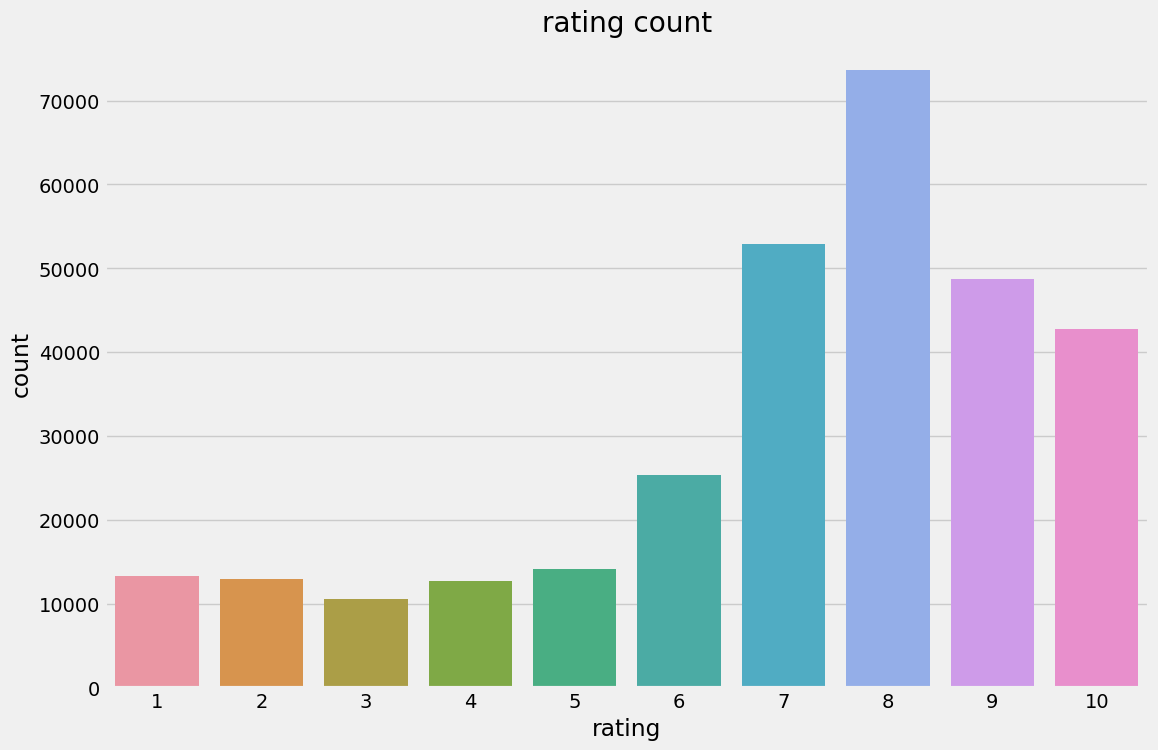

In [88]:
ratings['rating'].value_counts(normalize = True)
rating_count_df = pd.DataFrame(ratings['rating'].value_counts()).reset_index()
rating_count_df.T
plt.figure(figsize=(12, 8))
plt.style.use('fivethirtyeight')
sns.barplot(y = rating_count_df['count'], x = rating_count_df['rating'])
plt.title('rating count')
plt.show()

In [77]:
user_read_count_df = pd.DataFrame()

# for i in range()
# (ratings.groupby('user_id')['rating'].count()==1).value_counts()
ratings.groupby('user_id')['rating'].count().sort_values(ascending=False)

user_id
11676     5520
98391     4560
189835    1503
153662    1496
23902      956
          ... 
47317        1
150670       1
150676       1
150677       1
138957       1
Name: rating, Length: 59803, dtype: int64

In [78]:
# heavy user의 rating 부여 분포
heavy_users_list = ratings.groupby('user_id')['rating'].count().sort_values(ascending=False).head(20).index
ratings[ratings['user_id'].isin(heavy_users_list)].groupby('user_id')['rating'].mean()

user_id
11676     6.779891
16795     6.423684
23902     7.174686
35859     7.175896
56399     9.312036
76499     8.477778
95359     7.200820
98391     8.566228
101851    8.420354
114368    4.364389
153662    8.209893
158295    5.770270
171118    6.961089
177458    6.757794
182085    8.210269
185233    3.263914
189835    3.184298
197659    8.116170
235105    7.713054
248718    7.419009
Name: rating, dtype: float64

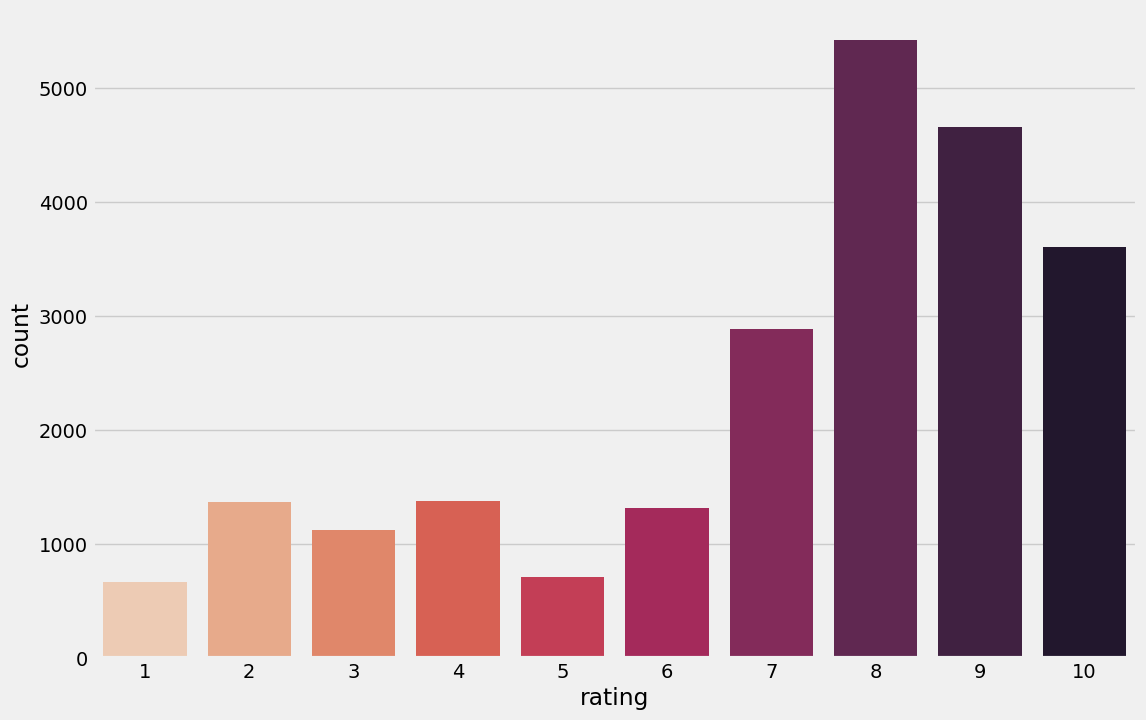

In [82]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8))
sns.countplot(data=ratings[ratings['user_id'].isin(heavy_users_list)], x='rating', palette='rocket_r')
plt.show()

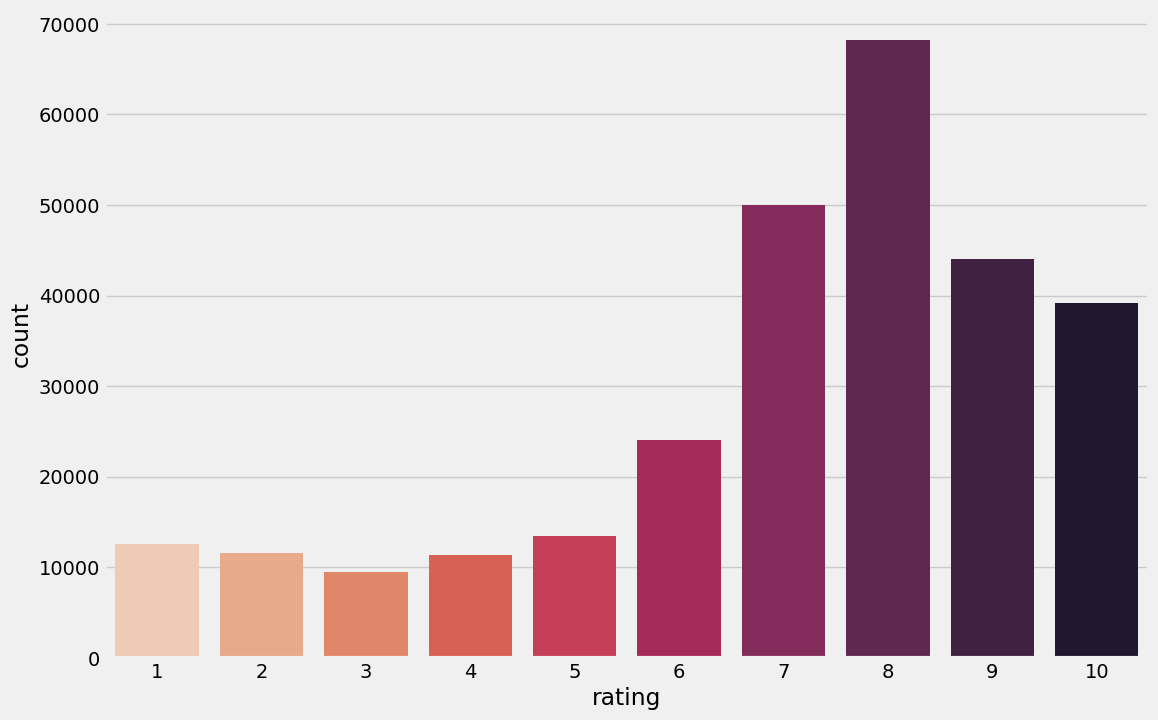

In [83]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8))
sns.countplot(data=ratings[~(ratings['user_id'].isin(heavy_users_list))] , x='rating', palette='rocket_r')
plt.show()

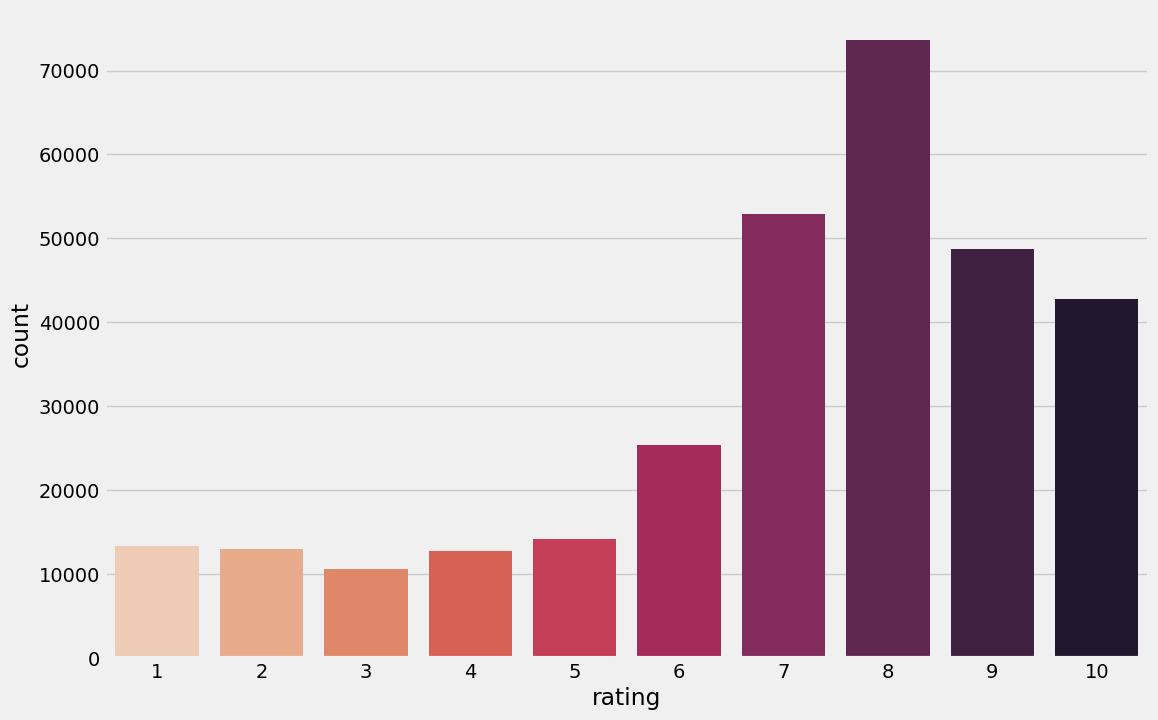

In [90]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8))
sns.countplot(data=ratings, x='rating', palette='rocket_r')
plt.show()

In [91]:
data = ratings.merge(books, how='left', on='isbn').merge(users, how='inner', on='user_id')
data.head()

,user_id,isbn,rating,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path,location,age
0,8,0002005018,4,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,['Actresses'],"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg,"timmins, ontario, canada",NaN
1,8,074322678X,4,Where You'll Find Me: And Other Stories,Ann Beattie,2002.0,Scribner,http://images.amazon.com/images/P/074322678X.0...,en,['Fiction'],"Now back in print, Ann Beattie&#39;s finest sh...",images/074322678X.01.THUMBZZZ.jpg,"timmins, ontario, canada",NaN
2,8,0887841740,2,The Middle Stories,Sheila Heti,2004.0,House of Anansi Press,http://images.amazon.com/images/P/0887841740.0...,NaN,NaN,NaN,images/0887841740.01.THUMBZZZ.jpg,"timmins, ontario, canada",NaN
3,8,1552041778,2,Jane Doe,R. J. Kaiser,1999.0,Mira Books,http://images.amazon.com/images/P/1552041778.0...,NaN,NaN,NaN,images/1552041778.01.THUMBZZZ.jpg,"timmins, ontario, canada",NaN
4,8,1567407781,6,The Witchfinder (Amos Walker Mystery Series),Loren D. Estleman,1998.0,Brilliance Audio - Trade,http://images.amazon.com/images/P/1567407781.0...,NaN,NaN,NaN,images/1567407781.01.THUMBZZZ.jpg,"timmins, ontario, canada",NaN


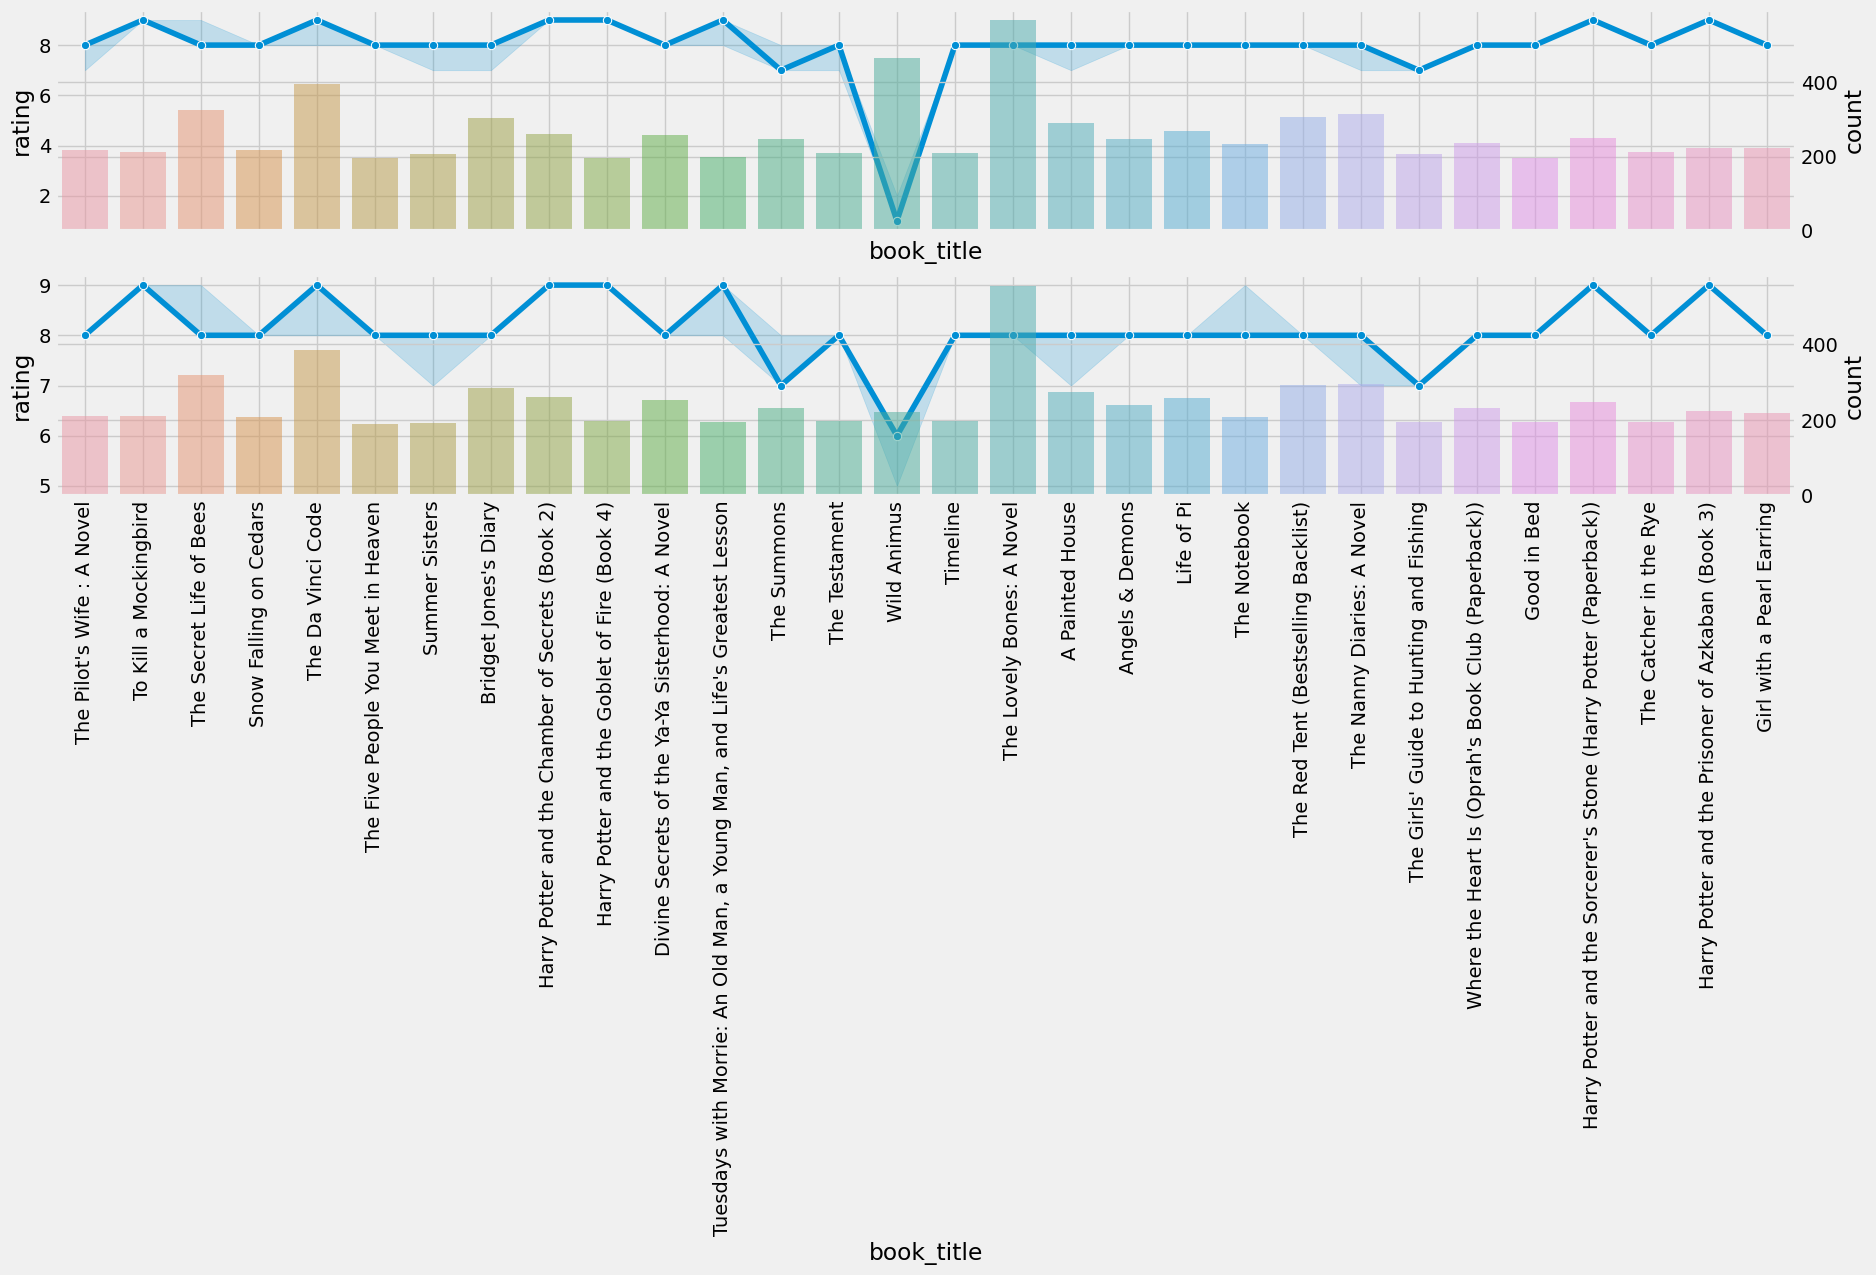

In [102]:
popular_book_list = data['book_title'].value_counts().sort_values(ascending=False)[:30].index
popular_book = data[data['book_title'].isin(popular_book_list)]

fig, ax1 = plt.subplots(2, 1, figsize=(20, 6))
plt.xticks(rotation=90)
plot1 = sns.lineplot(data=popular_book, x = 'book_title', y = 'rating', marker='o', estimator=np.median, ax=ax1[0])
plot1 = sns.countplot(data=popular_book, x='book_title', alpha=0.5, ax=ax1[0].twinx())
plot1.set_xticklabels([])

plot2 = sns.lineplot(data = popular_book[popular_book['rating']>1], x = 'book_title', y='rating', marker='o', estimator=np.median, ax=ax1[1])
plot2 = sns.countplot(data=popular_book[popular_book['rating']>1], x='book_title', alpha=0.5, ax=ax1[1].twinx())
plt.show()